# This sheet will generate and run the multiscale B-cell model

## Model Scope
The scope of this model is a combination of each of the individual models: NF-kB, Apoptosis, Cell Cycle and Differentiation. This is an updated version of the model published in MSB (https://doi.org/10.15252/msb.20145554) PNAS (https://doi.org/10.1073/pnas.1715639115) and Immunity (https://doi.org/10.1016/j.immuni.2019.02.004). The update from the published model is the more comprehensive NF-kB model as published in Rachel Tsui's thesis (https://escholarship.org/uc/item/4q05z4kh).

## Overview of the sheet

The sheet is broken down as follows:

* **Packages and parameters.** The environment is defined to control the size of the simulation, along with any perturbations requested (such as simulating drugs or mutations).
* **Function definitions.** All functions functions used in the model and result plotting phases are then provided with a basic description of what they do.
* **Run the model.** The above functions and parameters are used to run the model.
* **Output plotting.** This section will plot lineage trees, concentrations and cell counts for the simulation.

# Packages and parameters

In [1]:
################################################
### all the packages we need are defined here ##
################################################
using Logging
using Dates
using CSV
using DataFrames
using JLD2
using FileIO
using DifferentialEquations, DataFrames
using Plots 
using CSV
using Distributions
using Random
using SmoothingSplines
using Tables
using DelimitedFiles
import Base.Threads
using Base.Threads
using BSON: @save, @load

These parameters control everything about the simulation. The main ones you will want to test are:

- **numCells**, the number of founder cells to simulated
- **maxTimeTC**, the total time course length
- **maxGens**, how many generations can a cell divide before it is only allowed to die

In [2]:
###########################################################################
### Simulation Parameters #################################################
###########################################################################

###########################################################################
### Simulation Size #######################################################
###########################################################################
### do we want to incude delays?
delay=false # should we do ODEs or DDEs?

numCells=100 # number of starting cells
global maxTimeTC=float(60*120) # how long should the entire simulation run
maxGens=8 # maximum number of gens in total
startGen=1 # what gen to start out
preSimTime=60*24.0

maxTimeToWait=60*60*4; #Maximum number of seconds to wait after sending the
# last cell before giving up
SaveAllCells=true #saving all cell objects generates massive data, if you 
# only care about cell numnbers set this to false
###########################################################################

###########################################################################
### Heterogeiety parameters ###############################################
###########################################################################
preCV=0.11 # how much should we distribute starting parameters for each cell
#preCV=0.0 # how much should we distribute starting parameters for each cell
divCV=0 # If you set this to 0, only a single cell will be simulated for 
#divCV=0.072 # CV of asymmetric division.
# each lineage, which is a good approximation

###########################################################################

###########################################################################
### IKK stuff #############################################################
###########################################################################
totalIKK=280 #total IKK, IKK cruve scales between 0 and 100% of this value
basalIKK=totalIKK/100 # 1% at basal and at steady state phase
# basalIKK=totalIKK/2 # 1% at basal and at steady state phase

IKKMultiplier=1 # this can be used to scale IKK

#paramTime=[0,15,30,45,60,90,120,240,360,600,1440,3000,maxTimeTC]
#paramVals=[0,5,  10,13,19,32, 29, 27, 25, 20,  14,  12, 10]./100
# IKKParamVals=([1, 2, 7, 13, 19, 32, 29, 27, 25,
#         20, 14, 12, 10, 8, 4, 2, 1])./100 # IKK activity percentage

# IKKParamTime=[0, 15, 30 , 45, 60, 90, 120, 240, 360,
#     600, 1440, 1440*2, 1440*3, 1440*4, 1440*5, 1440*6, 1440*10] # Time 

IKKParamVals = [1, 1, 2, 7,13,19,  32, 29,  27,  20,  10,   1,     0,      0,      0,      0,      0]./100;
IKKParamTime = [0, 15,30,45,60,90, 120,240, 360, 600, 1440, 1440*2, 1440*3, 1440*4, 1440*5, 1440*6, 1440*10]; 

# IKKParamVals = [1, 1, 2, 7,13,19,  32, 32,  32,  32,  32,   32,     32,      32,      32,      32,      32]./100;
# IKKParamTime = [0, 15,30,45,60,90, 120,240, 360, 600, 1440, 1440*2, 1440*3, 1440*4, 1440*5, 1440*6, 1440*10]; 

# IKKParamVals = [1, 1, 1, 1,1,1,  1, 1,  1,  1,  1,   1,     1,      1,      1,      1,      1]./100;
# IKKParamTime = [0, 15,30,45,60,90, 120,240, 360, 600, 1440, 1440*2, 1440*3, 1440*4, 1440*5, 1440*6, 1440*10]; 


# IKKParamVals = [50,50,50]./100;
# IKKParamTime = [0, 1440, 1440*10]; 
    # points for the above percentages
###########################################################################

###########################################################################
### Death stuff ##########################################################
##########################################################################
ligandDose = 1.0 #the default value is 1.0, this provides a basal death 
# signal that will lead to cell death unless balanced by a survival signal
###########################################################################


###########################################################################
### Plotting parameters ###################################################
###########################################################################
plotSpacing=0.25 # how to space out the lineage tree
crossSize=0.1; # how big the crosses should be when a cell dies
###########################################################################

###########################################################################
### File locations  ######################################################
###########################################################################
### set up where CSV2Julia is
locationOfCSV2Julia="csv2Julia/csv2model-multiscale.py"
#we use the same initial conditions at the PNAS paper 2019 Mitchell Roy et al.
fullModelInitFile="initialConditions/fullModelInits.csv"
moduleDefinitionFilesFolder="moduleDefinitionFiles/"
global locationOfFixSpecies="utilityFunctions/"

###########################################################################
### Plotting options  #####################################################
###########################################################################
#colour for lineage tree output plot
thisColorPalette=palette(:seaborn_colorblind,maxGens);

If you want to perturb the system to represent either mutations or drugs that can be done below by either setting individual parameeters to change, or a range of parameters to scan automatically. Some examples are shown in the comments below.

In [3]:
###########################################################################
### Classic double hits ########################################################
###########################################################################
# uncomment conditions to run

# patient = "Myc_Bcl2_DH_x1.5"

# conditions=["WT","Myc_x1.5","Bcl2_x1.5","double hit"]
# paramsToChange=[["k2_scalingNumber-NFkB"],
#                 ["k1_mycExp-linking","k2_scalingNumber-NFkB"],
#                 ["k1_bcl2Exp-linking","k2_scalingNumber-NFkB"],
#                 ["k1_bcl2Exp-linking","k1_mycExp-linking","k2_scalingNumber-NFkB"]]
# modifyAmount=[[1.0],[1.5,1.0],[1.5,1.0],[1.5,1.5,1.0]]

# patient = "Myc_Bcl2_DH_x5"

# conditions=["WT","Myc_x5","Bcl2_x5","double hit"]
# paramsToChange=[["k2_scalingNumber-NFkB"],
#                 ["k1_mycExp-linking","k2_scalingNumber-NFkB"],
#                 ["k1_bcl2Exp-linking","k2_scalingNumber-NFkB"],
#                 ["k1_bcl2Exp-linking","k1_mycExp-linking","k2_scalingNumber-NFkB"]]
# modifyAmount=[[1.0],[5.0,1.0],[5.0,1.0],[5.0,5.0,1.0]]

# patient = "Myc_Bcl6_DH_x1.5"

# conditions=["WT","Myc_x1.5","Bcl2_x1.5","double hit"]
# paramsToChange=[["k2_scalingNumber-NFkB"],
#                 ["k1_mycExp-linking","k2_scalingNumber-NFkB"],
#                 ["k1_s_Bcl6-differentiation","k2_scalingNumber-NFkB"],
#                 ["k1_s_Bcl6-differentiation","k1_mycExp-linking","k2_scalingNumber-NFkB"]]
# modifyAmount=[[1.0],[1.5,1.0],[1.5,1.0],[1.5,1.5,1.0]]

# patient = "Myc_Bcl6_DH_x5"

# conditions=["WT","Myc_x5","Bcl2_x5","double hit"]
# paramsToChange=[["k2_scalingNumber-NFkB"],
#                 ["k1_mycExp-linking","k2_scalingNumber-NFkB"],
#                 ["k1_s_Bcl6-differentiation","k2_scalingNumber-NFkB"],
#                 ["k1_s_Bcl6-differentiation","k1_mycExp-linking","k2_scalingNumber-NFkB"]]
# modifyAmount=[[1.0],[5.0,1.0],[5.0,1.0],[5.0,5.0,1.0]]

###########################################################################

# Function Definitions

The below code defines all the functions we need to run the model. These could be included in a separate Julia file but they are left here for now so all the code is in the sample place.

### generateScanCombos
This function enables us to programatically generate all combinations of parameter changes when we need to do parameter scans.

In [4]:
################################################
### function to generate mutation combos #######
################################################
function generateScanCombos(DoseRange,ParamRange,ConditionNames,conditions,paramsToChange,modifyAmount,SSCondition)
    for i in DoseRange
        for j in DoseRange
            push!(modifyAmount,vcat(repeat([i],1,length(ParamRange[1][:]))',repeat([j],1,length(ParamRange[2][:]))')) 
            push!(paramsToChange,vcat(ParamRange[1][:],ParamRange[2][:]))
            if i==1 && j==1
                push!(conditions,SSCondition)
            elseif i==1
                push!(conditions,ConditionNames[2]*"_"*string(j))
            elseif j==1
                push!(conditions,ConditionNames[1]*"_"*string(i))
            else
                push!(conditions,ConditionNames[3]*"_"*string(i)*"_"*string(j))
            end
        end
    end
    (conditions,paramsToChange,modifyAmount)
end

generateScanCombos (generic function with 1 method)

### sampleInit
This function takes an array of concentrations and splits it into two slightly uneven arrays with a defined CV. This is used for cell division when divCV>0. Usually divCV should be set to zero for speed, as within-lineage variability is negligible in most contexts.

### myLogNormal
Generates a LogNormal distirbution from a mean and standard deviation

In [5]:
################################################
####### define the distributions we need #######
################################################
function sampleInit(y0,cv)
    #note mean of distribution is 1 so CV = standard deviation
    distribution=Truncated(myLogNormal(1,cv),0,Inf)
    scaling=rand(distribution, 1)
    scaling=scaling[1]
    ynew=y0.*scaling
    scalingInv=1+(1-scaling)
    ynewinv=y0.*scalingInv
    return abs.(ynew), abs.(ynewinv)
end
function myLogNormal(m,std)
    γ = 1+std^2/m^2
    μ = log(m/sqrt(γ))
    σ = sqrt(log(γ))

    return LogNormal(μ,σ)
end

myLogNormal (generic function with 1 method)

### generateIKKFunctions
Generates two functions that take time as parameters and returns IKK activity values. ikkSS is used for the steady-state phase and uses basal IKK. ikkTC defines the dynamic time course.

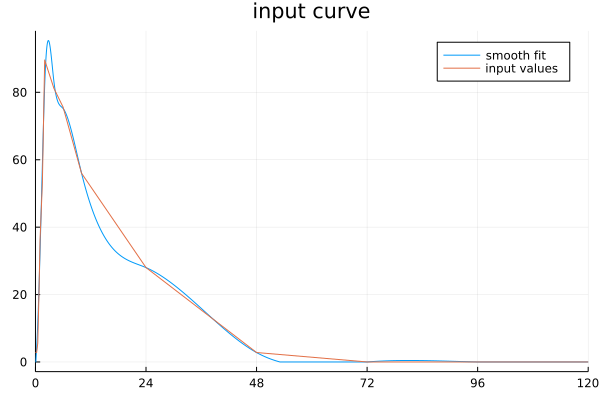

Defined IKK input curve.


In [6]:
################################################
#### define the IKK input function we need #####
################################################
# this uses the values and time points and fits a smooth curve
function generateIKKFunctions(IKKParamTime,IKKParamVals,IKKMultiplier,totalIKK,basalIKK)
    X = map(Float64,IKKParamTime)
    Y = map(Float64,IKKParamVals)
    spl = fit(SmoothingSpline, X, Y,10000.0) # λ=250.0
    Ypred = predict(spl,1.0:maxTimeTC) # fitted vector

    #the IKK function is just maps to basal IKK during SS and basal+the IKK curve during the time course.
    ikkSS=t->basalIKK
    ikkTC=t->(maximum([predict(spl,t),0])*IKKMultiplier*totalIKK);
    p=plot([1:1:maxTimeTC],ikkTC.(1:1:maxTimeTC),label="smooth fit",title="input curve")
    plot!(IKKParamTime,IKKParamVals.*IKKMultiplier.*totalIKK,label="input values",xlim=(0,maxTimeTC),xticks = (0:60*24:maxTimeTC, string.(0:24:Int64(maxTimeTC))))
    display(p)
    xlabel!("time (h)")
    ylabel!("active IKK")
    return ikkSS,ikkTC
end

 # generate the IKK curves
global ikkSS,ikkTC=generateIKKFunctions(IKKParamTime,IKKParamVals,IKKMultiplier,totalIKK,basalIKK)
# run all conditions! Godspeed B-cels
global tdfunc=t->ikkSS(t)
println("Defined IKK input curve.")

In [7]:
################################################
#### define the IKK input function we need #####
################################################
# this uses the values and time points and fits a smooth curve

### FOR MUTATION TESTING
# function generateIKKFunctions(IKKParamTime,IKKParamVals,IKKMultiplier,totalIKK,basalIKK)
#     X = map(Float64,IKKParamTime)
#     Y = map(Float64,IKKParamVals)
#     spl = fit(SmoothingSpline, X, Y,10000.0) # λ=250.0
#     Ypred = predict(spl,1.0:maxTimeTC) # fitted vector

#     #the IKK function is just maps to basal IKK during SS and basal+the IKK curve during the time course.
#     ikkSS=t->basalIKK
#     ikkTC=t->basalIKK
#     #ikkTC=t->(maximum([predict(spl,t),0])*IKKMultiplier*totalIKK);
#     p=plot([1:1:maxTimeTC],ikkTC.(1:1:maxTimeTC),label="smooth fit",title="input curve")
#     #plot!(IKKParamTime,IKKParamVals.*IKKMultiplier.*totalIKK,label="input values",xlim=(0,maxTimeTC),xticks = (0:60*24:maxTimeTC, string.(0:24:Int64(maxTimeTC))))
#     display(p)
#     xlabel!("time (h)")
#     ylabel!("active IKK")
#     return ikkSS,ikkTC
# end

### combineModels
This function takes multiple modules and links them togther uses reactions defined in the "linking" module. This is broadly the same as copying each reactions, parameters and rateLaws CSV file below each other to create a large combined CSV file. The only difference is that if a reaction is defined twice, the reaction in the "linking" module override the other reaction, which will be deleted. Parameters have the nave of their module appended so that having the same paramter name in each module does not cause issues.

In [8]:
function combineModels()
    ################################################
    ### Create a combined model from the modules ###
    ################################################
    #first lets tell Julia where the files are
    modulesToInclude=["NFkB","cellCycle","apoptosis","differentiation"]
    linkingModuleName="linking"
    combinedModelLocation="combinedModelDefinitionFiles/"
    mkpath(combinedModelLocation)


    #first lets load the linking file so we know to skip any reactions 
    #which are doubly described by the linking file and one of the modules
    linkingReactions=""
    if(delay)
        linkingReactions = DataFrame(CSV.File(moduleDefinitionFilesFolder*linkingModuleName*"/reactions_withDelay.csv",stringtype=String,types=String))
    else
        linkingReactions = DataFrame(CSV.File(moduleDefinitionFilesFolder*linkingModuleName*"/reactions.csv",stringtype=String,types=String))
    end
    linkingParameters = DataFrame(CSV.File(moduleDefinitionFilesFolder*linkingModuleName*"/parameters.csv",stringtype=String,types=String))
    linkingrateLaws = DataFrame(CSV.File(moduleDefinitionFilesFolder*linkingModuleName*"/rateLaws.csv",stringtype=String,types=String))

    #missing values mess things up so replace with empty strings
    replace!(linkingReactions.Substrate, missing => "")
    replace!(linkingReactions.Products, missing => "")

    #we know we need all the linking reactions in the combined model
    reactionsCombined=linkingReactions
    parametersCombined=linkingParameters
    linkingParameters[:,1]=linkingParameters[:,1].*("-"*"linking")
    theseParams=linkingReactions.Parameters
    replacementParams=""
    newParams=theseParams
    thisLine=1
    for param in theseParams
        if ismissing(param)
            thisLine=thisLine+1
        else
            eachParam=split(param," ")
            eachParam=[i*"-"*"linking" for i in eachParam]
            replacementParams=join(eachParam," ")
            newParams[thisLine]=replacementParams
            thisLine=thisLine+1
        end
    end
    linkingReactions.Parameters=newParams
    rateLawsCombined=linkingrateLaws

    # loop through each model
    for mod in modulesToInclude
        print("adding $(mod) module\n")

        thisModule=moduleDefinitionFilesFolder*mod
        #the NFkB file can have delays but the rest do not
        reactionFile=""
        if mod=="NFkB" && delay
            reactionFile=thisModule*"/reactions_withDelay.csv"
        else
            reactionFile=thisModule*"/reactions.csv"
        end
        parameterFile=thisModule*"/parameters.csv"
        rateLawsFile=thisModule*"/rateLaws.csv"

        parameterDF = CSV.read(parameterFile,DataFrame,stringtype=String,types=String)
        rateLawDF = CSV.read(rateLawsFile,DataFrame,stringtype=String,types=String)
        reactionDF = CSV.read(reactionFile,DataFrame,stringtype=String,types=String)
        #not every entry in the reaction database is filled in and missing data can cause a problem
        replace!(reactionDF.Substrate, missing => "")
        replace!(reactionDF.Products, missing => "")

        #keep track of rows to remove
        #these are rows that appear in individual module reaction files 
        #and are replaced by reactions in the linking module.
        rowsToRemove=[]
        thisRow=1
        for row in eachrow(reactionDF)
            if nrow(linkingReactions[(linkingReactions[!,"Substrate"].==row.Substrate).&(linkingReactions[!,"Products"].==row.Products),:])>0
                print("removing: $(row.Substrate) -> $(row.Products) as it is included in linking file\n")
                push!(rowsToRemove,thisRow)
            end
            thisRow=thisRow+1
        end
        delete!(reactionDF, rowsToRemove)
        print("adding module $(mod) to combined reaction array\n")

        #we need to append a module ID on each parameter name in the reactions file 
        #because some parameters have the same name in multiple modules
        theseParams=reactionDF.Parameters
        replacementParams=""
        newParams=theseParams
        thisLine=1
        for param in theseParams
            eachParam=split(param," ")
            eachParam=[i*"-"*mod for i in eachParam]
            replacementParams=join(eachParam," ")
            newParams[thisLine]=replacementParams
            thisLine=thisLine+1
        end
        reactionDF.Parameters=newParams
        append!(reactionsCombined,reactionDF)

        #do the same, prepending in the parameters file for the combined model
        parameterDF = CSV.read(parameterFile,DataFrame,stringtype=String,types=String)
        rowsToRemove=[]
        thisRow=1
        for row in eachrow(parameterDF)
            if nrow(linkingParameters[(linkingParameters[!,"parameter"].==row.parameter),:])>0
                print("removing: $(row.parameter) as it is included in linking file\n")
                push!(rowsToRemove,thisRow)
            elseif occursin("p[",row.value)
                print("removing: $(row.parameter) as it includes p[t]\n")
                push!(rowsToRemove,thisRow)
            end

            thisRow=thisRow+1
        end
        delete!(parameterDF, rowsToRemove)

        theseParams=parameterDF.parameter
        parameterDF.parameter=parameterDF.parameter.*("-"*mod)

        append!(parametersCombined,parameterDF)

        #rate law duplication seems ok and unambiguous for now
        rateLawsDF=CSV.read(rateLawsFile,DataFrame;stringtype=String,types=String)
        append!(rateLawsCombined,rateLawsDF)

        print("finished $(mod)\n\n")
    end
    #write out the combined model
    CSV.write(combinedModelLocation*"reactions.csv", reactionsCombined)
    CSV.write(combinedModelLocation*"parameters.csv", parametersCombined)
    CSV.write(combinedModelLocation*"rateLaws.csv", rateLawsCombined)
    print("finished combining all modules\n")
    return combinedModelLocation
end

combineModels (generic function with 1 method)

### getWhichParamsToDistribute
Not all parameters are distirbuted, in fact only those with a "1" in the "distribute" column are distributed. These are broadly expression and degradation rates as we assume all other parameters are conserved. This funciton simply loads combined paramters file and stores whether or not each parameter should be distributed in a dictionary.

In [9]:
function getWhichParamsToDistribute(combinedModelLocation)
    ################################################
    ###### Create distributed starting states ######
    ################################################
    distributeDict=Dict()
    #reload parameter file from CSV
    parametersFile = DataFrame(CSV.File(combinedModelLocation*"parameters.csv",types=Dict(:parameter=>String, :value=>String, :distribute=>Int64)))
    #thisDist=TruncatedNormal(1.0, preCV,0,Inf)
    #     mkpath(distributedCombinedModelLocation)
    #     #for every starting cell required
    thisParams=deepcopy(parametersFile)
    originalParams=deepcopy(thisParams)

    distributedCombinedModelLocation="distrbutedCombinedModelDefinitionFiles/"
    mkpath(distributedCombinedModelLocation)
    #println(thisParams[thisParams.parameter .== paramsToChange[1],"value"])
    totalParameters=0
    #loop through every parameter and determine if it is meant to be distirbuted
    for j in 1:size(thisParams,1)
        global distributeDict[thisParams[j,1]]=thisParams[j,3]
        totalParameters+=1
    end
    @info("identifying which params to distirbute \n");flush(io)
    println("identifying which params to distirbute\n")
    return distributeDict,totalParameters
end


getWhichParamsToDistribute (generic function with 1 method)

### buildModels
This funtion will actually run csv2Julia on the newly combined files to generate the new model.

In [10]:
function buildModels(combinedModelLocation)
    ################################################
    ############### build the model(s) #############
    ################################################
    mkpath("modelFiles/")

    #identify the three CSV sheets that describe the model
    reactionsFile=combinedModelLocation*"reactions.csv"
    parametersFile=combinedModelLocation*"parameters.csv"
    rateLawsFile=combinedModelLocation*"rateLaws.csv"


    #build a command to execute csv2julia
    location=[locationOfCSV2Julia]
    arguments=[reactionsFile, parametersFile, rateLawsFile,"odeMultiscaleModel.jl","param"]
    cmd=`python3 $locationOfCSV2Julia $arguments`

    #lets run csv2julia (requires python to be installed)
    run(cmd)
    
    #pop the outputs in a modelFiles folder
    mv("odeMultiscaleModel.jl","modelFiles/odeMultiscaleModel.jl", force=true)
    mv("scanIncludes.jl","modelFiles/scanIncludes.jl", force=true)
    mv("variableNames.jl","modelFiles/variableNames.jl", force=true);

end

buildModels (generic function with 1 method)

### loadInitialConditions
This function will load the initial conditions of each model from the appropriate CSV files into an initial conditions array for the whole model.

In [11]:
function loadInitialConditions()
################################################
########## Load the initial conditions #########
################################################
    include("modelFiles/variableNames.jl")
    InitConds=zeros(length(syms),1)

    fullModelInits=CSV.read(fullModelInitFile,DataFrame)
    for i=1:size(fullModelInits,1)
        #println(fullModelInits[i,1])
        indexOfThisVar=findfirst(x->fullModelInits[i,1]==x,syms)    
        InitConds[indexOfThisVar]=fullModelInits[i,2]
    end


    #all initial conditions loaded, saving to a CSV file for future reference.
    df=DataFrame(InitConds,:auto)
    insertcols!(df, 1, :names=>syms)
    mkpath("SSDoutputs/")
    mkpath("SSDoutputs/processedCells")
    mkpath("SSDoutputs/unprocessedCells")
    mkpath("SSDoutputs/cellsInProgress")
    CSV.write("SSDoutputs/initialConditions.csv",df);
    println("Initial conditions loaded")
    return InitConds
end

loadInitialConditions (generic function with 1 method)

### struct cell
This is a custom structure used to store information about every cell that we solve. This structure is saved onto the disk and contains all the information to load the cell and solve it, and then save the result to the structure. This way cells can be queued by placing them in the folder of cells to process and when complete they can be saved into the processed cells folder.

In [12]:
################################################
###### define a structure to store cells #######
################################################
mutable struct cell
    generation::Int64
    ID::Int64
    motherCellID::Int64
    founderCellID::Int64
    ODEFile::String
    fate::Int64 #0 = unknown, 1 = division, 2 = death
    tBirth::Float64
    tDeath::Float64
    solutionObject #the entire solution object. If you don't need this comment it out for efficiency.
    y0::Matrix{Float64} #initial conditions.
    yCoord::Float64 #for plotting lineage trees
    leftDaughterID::Int64
    rightDaughterID::Int64
    parameterList
    parameterNameList::Vector{String}
    cellsRepresented::Int64
    #newSwitch::Int64
end    

### Callbacks
There are a number of callbacks used for the model, most are kept the same as in inidividual models.

**affectCdhNoNewCells** is used during the steady state phase as we want the cell to "divide" but we don't want to end the simulation, we want to keep going until we get to steady state.

Callback sets are defined for the steady-state phase, the main time course phase, and the final generation where no future divisions are allowed.

In [13]:
################################################
########### define all the callbacks ###########
################################################
#first lets define the switch event for the cell cycle ribosome usage.
function condition(cellcycle,t,integrator) # Event when event_f(u,t) == 0
    #include("modelFiles/variableNames.jl")
    #numberator: Rb + E2F:Rb +  pE2F:Rb
    #denominator: Rb + E2F:Rb +  pE2F:Rb + hypophosphorylated Rb
    numerator= cellcycle[indexOfRb]+cellcycle[indexOfE2FRb]+cellcycle[indexOfpE2FRb];  #ACTIVE RB
    denominator = numerator+cellcycle[indexOfHypoPRb]; #TOTAL RB

    #GM growth (biosynthesis of ribosomes and all necessary machinery)
    #previous iterations had numerator/denominator<0.8
    #diffEq.jl requires a function that hits 0
    (numerator/denominator)-0.8
end

function affect!(integrator)
  #update r31Switch to 0
  integrator.u[indexOfSwitch] = 0
end
function affectNeg!(integrator)
  #update r31Switch to 1
  integrator.u[indexOfSwitch] = 1
end

# now lets define the cell division event
function conditionCdh(cellcycle,t,integrator) # Event when event_f(u,t) == 0
      #include("modelFiles/variableNames.jl")
      #triggers when Cdh1 crosses 0.2 in the positive direction
      cellcycle[indexOfCdh1]-0.2
end

#in multiscale modeling this should introduce two new simulations
function affectCdh!(integrator)
  #print("cell divided - callback\n")
  if integrator.u[indexOfMass]<1.0
    integrator.uprev[indexOfNewSwitch]=0
    integrator.u[indexOfNewSwitch]=0
  else
    #print("new switch 1 during division\n")
    integrator.uprev[indexOfNewSwitch]=1
    integrator.u[indexOfNewSwitch]=1
    integrator.uprev[indexOfFateSwitch]=1 #division
    integrator.u[indexOfFateSwitch]=1    
    #step!(integrator)
    terminate!(integrator)
  end

end

#now lets define the cell death events
function conditionCPARP(species,t,integrator) # Event when event_f(u,t) == 0 

      #triggers when Cdh1 crosses 0.2 in the positive direction
      species[indexOfCPARP]-2500
end
#in multiscale modeling this should introduce two new simulations, but for now lets just divide this one cell
function affectCPARP!(integrator)
  #uncomment the below lines to restore death, made cells immortal for testing
  #kill the cell and the integration
  integrator.uprev[indexOfFateSwitch]=2 #death
  integrator.u[indexOfFateSwitch]=2
  #step!(integrator)    
  terminate!(integrator)
end

function affectCdhNoNewCells!(integrator)
  #this clalback will divide the concentrations but not terminate the integrator to create new cells
  #triggers when Cdh1 crosses 0.2 in the positive direction
  #update Mass to 0.5* mass
  integrator.u[indexOfMass] = 0.5*integrator.u[indexOfMass]
  #Gm to 0.5 * Gm
  #update everything to 0.5* previous concentrations
  integrator.u[indexOfGM]=0.5*integrator.u[indexOfGM]
  integrator.u[indexOfSwitch]=1
  integrator.u[indexOfBcl2t]=277
  integrator.u[indexOfCdh1]=1.0   #required to prevent it dividing again very quickly. this is done in shokhirev et al.
end

function getCallbackSets()

    #use and combine the callbacks described above to trigger events
    cb = ContinuousCallback(condition,affect!,affectNeg!,save_positions=(true,true))
    cb2 = ContinuousCallback(conditionCdh,affectCdh!,nothing,save_positions=(true,true))
    cb3 = ContinuousCallback(conditionCPARP,affectCPARP!,nothing,save_positions=(true,true))
    cb4 = ContinuousCallback(conditionCdh,affectCdhNoNewCells!,nothing,save_positions=(true,true))
    cbs=CallbackSet(cb,cb2,cb3);
    cbNoDivision=CallbackSet(cb,cb3); #used when we don't want cells to divide
    cbSteadyState=CallbackSet(cb,cb4); #used in initial stage where we want division but not to create new cells
    println("All callbacks defined")
    return cbs,cbNoDivision,cbSteadyState
end

getCallbackSets (generic function with 1 method)

In [14]:
## callback with newSwitch

#in multiscale modeling this should introduce two new simulations
# function affectCdh!(integrator)
#   #print("cell divided - callback\n")
#   if integrator.u[indexOfMass]<1.0
#     integrator.uprev[indexNewSwitch]=0
#     integrator.u[indexNewSwitch]=0
#   else
#     #print("new switch 1 during division\n")
#     integrator.uprev[indexNewSwitch]=1
#     integrator.u[indexNewSwitch]=1
#   end
#   integrator.uprev[indexOfFateSwitch]=1 #division
#   integrator.u[indexOfFateSwitch]=1    
#   #step!(integrator)
#   terminate!(integrator)
# end

### updatePlotToCSVNew
This function updates the treeArray variable which is used to store the generation times of each lineages to enable plotting of lineage trees. This function also updates the cellCounts.csv array to enable plotting of total cell numbers afterwards.

In [15]:
################################################
#### update the output file for plotting #######
################################################

function updatePlotToCSVNew(founderID,gen,fateTime)
    @info("running update plot new for ID: "*string(founderID)*"\n");flush(io)
    global csvFileOwned
    while csvFileOwned
        exec_time = rand()
        sleep(exec_time)  
    end
    csvFileOwned=true
    global treeArray[founderID,gen]=fateTime
    global treeArray[founderID,end]=gen
       #  we write to the cellCounts file, which shos how many cells we had of each generation
    cellsRepresented=2^(gen-1)
    startTime=1
    if gen==1
        startTime=1
    else
        startTime=treeArray[founderID,gen-1]
    end
    try
        if startTime!=fateTime
            toWriteCellCounts=zeros(1,Int64(round(maxTimeTC)))
            toWriteCellCounts[Int64(round(startTime)):Int64(minimum([round(maxTimeTC),round(maximum([fateTime-1,startTime+1]))]))].=(1*gen)
            toWriteCellCounts=repeat(toWriteCellCounts,cellsRepresented,1)
            CSV.write("cellCounts.csv",  Tables.table(toWriteCellCounts), writeheader=false, append=true, newline='\n')
            message="cellCounts.csv updated between: "*string(Int64(round(startTime)))*", and: "*string(Int64(round(fateTime)))*", with "*string((1*gen))*"\n"
            @info(message); flush(io)
        end
    catch err
        @info("couldn't write to cellCounts.csv "*string(err)*"\n"); flush(io)
    end
    csvFileOwned=false
    
end

updatePlotToCSVNew (generic function with 1 method)

In [16]:
function generateProb(delay,y0,preSimTime,params)
    global symsSymbol
    if delay
        f=DDEFunction(odeMultiscaleModel!,syms=symsSymbol)
        h(p,t)=y0
        prob=DDEProblem(f,y0,h,(0.0,preSimTime),params)
    else
        f=ODEFunction(odeMultiscaleModel!,syms=symsSymbol)
        prob=ODEProblem(f,y0,(0.0,preSimTime),params)
    end
    return prob
end

generateProb (generic function with 1 method)

### findSSOfCell
This function take the initial conditions of the cell and finds the steady state by running it for a long time The initial conditions of the dynamic phase are taken from the final state of this steady-state phase.

In [17]:
function findSSOfCell(InitConds,delay,preSimTime,ikkSS,distributeDict,paramVals,parameterNameList,ID)
    tdfunc=t->ikkSS(t)
    InitConds[indexOfBcl2t]=277
    InitConds[indexOfLigand]=0.0
    
    lengthOfParamList=length(paramVals)
    for paramIndex in 1:lengthOfParamList
        if paramVals[paramIndex] isa Float64 || paramVals[paramIndex] isa Int64
        else
            paramVals[paramIndex]=t->tdfunc(t)
        end
    end
    prob=generateProb(delay,InitConds,preSimTime,paramVals)
    
    thisSol=solve(prob,Rodas4(),callback=cbSteadyState,abstol = 1e-5, reltol = 1e-3)
    df=DataFrame(thisSol)
    CSV.write("SSDoutputs/preSimPerCell/preSimCell-"*string(ID)*".csv",df)
    
    initSol=thisSol[end]
    
    initSol[indexOfCdh1]=1
    initSol[indexOfIRF4]=0
    initSol[indexOfAID]=0
    initSol[indexOfBlimp1]=0
    initSol[indexOfPax5]=1
    initSol[indexOfBcl6]=0
    initSol[indexOfLigand]=ligandDose
    
    return  initSol
end
               

findSSOfCell (generic function with 1 method)

### createCell

This function creates a cell, by populating the custom struct defined above. If the cell is the 1st generation it will solve the steady state phase, otherwise  this basicall just populates the struct. 

As there are time dependent paramters and these functions cannot be saved to the disk, each time dependent parameter is updated to a string before saving. These strings are converted back into functions before running.

In [18]:
################################################
###### define the createCell function ##########
################################################
# this function simply saves a bunch of new cell objects to the unprocessed cells folder

function createCell(y0,gen,startTime,yCoord,hist,delay,founderCellID,odeFile,motherCellID,paramVals,parameterNameList,cellsRepresented)
    global nextFreeCellID
    ID=Threads.atomic_add!(nextFreeCellID, 1)
    message="new cell gen: "*string(gen)*". startTime:"*string(startTime)*". ID: "*string(ID)*". yCoord: "*string(yCoord)*"\n"
    @info(message); flush(io)
    startTime=float(startTime)
#     global indexOfCdh1
#     global indexOfCPARP
#     global indexOfFateSwitch
#     global mechanicalDeathTime
#     global startGen
#     global distribute
#     global preCV
#     global distributeDict
    fate=0
    tDeath=0
    if gen==1
        @info("finding SS of cell "*string(ID)*".\n"); flush(io)
        y0 = findSSOfCell(InitConds,delay,preSimTime,ikkSS,distributeDict,paramVals,parameterNameList,ID)
        @info("SS found of cell "*string(ID)*".\n"); flush(io)
        df=DataFrame(y0,:auto)
        CSV.write("SSDoutputs/initCondsPerCell/initConds-"*string(ID)*".csv",df)
        
        #parameters to change between SS and dynamic phase here
        #lets stabilise NIK!

        indexOfParam=findfirst(x->"k1_NIKConstDeg-NFkB"==x,parameterNameList)
        paramVals[indexOfParam]=paramVals[indexOfParam]./10
    end
#     if gen==maxGens
#         y0[indexOfLigand]=10
#     end
    thisCell=cell(gen,ID,motherCellID,founderCellID,odeFile,fate,startTime,0.0,nothing,y0,yCoord,0.0,0.0,paramVals,parameterNameList,cellsRepresented)

    @info("About to save cell "*string(ID)*".\n"); flush(io)
    unprocessedLocation=joinpath("SSDoutputs/", "unprocessedCells/")
    
    lengthOfParamList=length(thisCell.parameterList)
    for paramIndex in 1:lengthOfParamList
        if thisCell.parameterList[paramIndex] isa Float64 || thisCell.parameterList[paramIndex] isa Int64
        else
            thisCell.parameterList[paramIndex]="tdfunc"
        end
    end
    #save(unprocessedLocation*"cell_"*string(ID)*".jld2", "thisCell",thisCell)
    @save unprocessedLocation*"cell_"*string(ID)*".jld2" thisCell # Same as above
    return ID
end
    

createCell (generic function with 1 method)

### initialiseFirstCells
This function will defined all the initial cells, inckuding distributing appropriate parameters for each cell. It then calls createCell to write the cell into a struct and save it to the unprocessed cells folder.

In [19]:
################################################
######## define initialiseFirstCells  ##########
################################################
# This function creates a bunch of cells using createCell()
function initialiseFirstCells(numCells,initSol,delay,condition,paramVals,parameterNameList,parametersDistributions,distributeDict)
#     global indexOfCPARP
#     global indexOfCdh1
#     global preConcCV
#     global modifyDict
#     global modify
#     global hardCodedParams
    startTime=1
    mkpath("SSDoutputs/paramValsForCell/")
    mkpath("SSDoutputs/initCondsPerCell/")
    mkpath("SSDoutputs/preSimPerCell/")
    Threads.@threads for i in 1:numCells
    #for i in 1:numCells
        @info("Creating cell "*string(i)* ".\n"); flush(io) 
        odeFileLocation=""
        ID=i
        founderCellID=ID
        hist=nothing
        thisCellsParamVals=deepcopy(paramVals)
        thisCellsRands=parametersDistributions[:,i]
        for (paramName,distributeBool) in distributeDict
            if distributeBool==1
                indexOfParam=findfirst(x->paramName==x,parameterNameList)
                thisCellsParamVals[indexOfParam]=thisCellsParamVals[indexOfParam].*thisCellsRands[indexOfParam]
            end
        end
        toSave=hcat(parameterNameList,thisCellsParamVals)
        df=DataFrame(toSave,["paramName","paramVal"])
        CSV.write("SSDoutputs/paramValsForCell/paramValsForCell-"*string(i)*".csv",df)
        if delay
            hist(p,t)=thisInit 
        else
            hist = nothing
        end
        createCell(initSol,startGen,startTime,ID,hist,delay,ID,odeFileLocation,ID,thisCellsParamVals,parameterNameList,1)
    end
end

initialiseFirstCells (generic function with 1 method)

### processCell
This function is used to run the cell. It does everything except call "solve" on the ODE, which is handled by a call to the "runCell" function.

This function will load the cell from the unprocessed cells location. It will then return any time dependent parameters that have been converted to strings back into functions. Finally it will call "runCell" on the cell and then save the processed  cell to the processed cells folder.

In [20]:
function processCell(cellPath)
        success = true
        @info("loading cell from: "*string(cellPath)*"\n",);flush(io)
        thisCell = try
            @load cellPath thisCell
            @info("loaded cell: "*string(thisCell.ID)*" successfully\n",);flush(io)
            thisCell
        catch err
            success=false
            @info("error, couldn't load cell: "*string(cellPath)*"\n");flush(io)
            @info(err)
            bt = backtrace()
            msg = sprint(showerror, err, bt)
            @info(msg);flush(io)
            @info(cellPath);flush(io)
            mkpath("SSDoutputs/erroredCells")
            dateStamp=Dates.now()
            #save("SSDoutputs/erroredCells/"*"cell_"*string(thisCell.ID)*"-$(dateStamp).jld2", "thisCell",thisCell)
            @save "SSDoutputs/erroredCells/"*"cell_"*string(thisCell.ID)*"-$(dateStamp).jld2" cellPath
        
            rm(cellPath)
        end
        if success
            #thisCell=load(cellPath,"thisCell")#creates -> #thisCell
            lengthOfParamList=length(thisCell.parameterList)
            for paramIndex in 1:lengthOfParamList
                if thisCell.parameterList[paramIndex] isa Float64 || thisCell.parameterList[paramIndex] isa Int64
                else
                    thisCell.parameterList[paramIndex]=t->tdfunc(t)
                end
            end
            
            try
                #@info("about to runCell on cell: "*string(thisCell.ID)*"\n",);flush(io)
                thisCell=runCell(thisCell) 
                #@info("runCellCompleted on: "*string(thisCell.ID)*"\n",);flush(io)
                #thisCell = runCell(thisCell)
            catch err
                success=false
                @info("error, couldn't solve cell: "*string(thisCell.ID)*"\n");flush(io)
                @info(err)
                bt = backtrace()
                msg = sprint(showerror, err, bt)
                @info(msg);flush(io)
                @info(thisCell);flush(io)
                mkpath("SSDoutputs/erroredCells")
                dateStamp=Dates.now()
                #save("SSDoutputs/erroredCells/"*"cell_"*string(thisCell.ID)*"-$(dateStamp).jld2", "thisCell",thisCell)
                @save "SSDoutputs/erroredCells/"*"cell_"*string(thisCell.ID)*"-$(dateStamp).jld2" thisCell

                rm(cellPath)

            end
        end
        if success
            try
                processedCellLocation=joinpath("SSDoutputs/", "processedCells/")
                #save(processedCellLocation*"cell_"*string(thisCell.ID)*".jld2", "thisCell",thisCell)
                @save processedCellLocation*"cell_"*string(thisCell.ID)*".jld2" thisCell
                rm(cellPath)
            catch err
                @info("couldn't save solved cell: "*string(thisCell.ID)*", saving to failedCells\n");flush(io)
                bt = backtrace()
                msg = sprint(showerror, err, bt)
                @info(msg);flush(io)
                mkpath("SSDoutputs/erroredCells")
                dateStamp=Dates.now()
                #save("SSDoutputs/erroredCells/"*"cell_"*string(thisCell.ID)*"-$(dateStamp).jld2", "thisCell",thisCell)
                @save "SSDoutputs/erroredCells/"*"cell_"*string(thisCell.ID)*"-$(dateStamp).jld2" thisCell
            end
        end
    return nothing
end

processCell (generic function with 1 method)

### runSimulation
This function is the main function to run the simulations. It will load unprocessed cells from the folder, send them for processing to each thread enabling many to be solved simultaneously.

In [21]:
################################################
### define the main runSimulation function #####
################################################
# This function loops through the unprocessedCells and processes them.
# if new cells are created, due to division, they will be added to 
# unprocessed cells and processed. 
# We can only be sure the simulation is finished when both folders are
# empty.
function runSimulation()
    timeToSleep=5
    while !isempty(filter(!startswith("."), readdir("SSDoutputs/unprocessedCells")))
        filesToAddThisStep=0
        anythingAdded=false
        
        #if we are here there are cells to process
        filesInDir=readdir("SSDoutputs/unprocessedCells")
        filesInDir=filter(!startswith("."), filesInDir)

        numberOfFilesInDir=length(filesInDir)
        @info("there are "*string(numberOfFilesInDir)*" cells to process currently\n",);flush(io)

        #filesToAddThisStep=minimum([numberOfCoresToUse-currentJobs[],numberOfFilesInDir])
        Threads.@threads for i in 1:numberOfFilesInDir
        #for i in 1:filesToAddThisStep
            fileToProcess=filesInDir[i];
            mv(joinpath("SSDoutputs/","unprocessedCells/",fileToProcess),joinpath("SSDoutputs/","cellsInProgress/", fileToProcess),force=true)
            cellPath=joinpath("SSDoutputs/","cellsInProgress/", fileToProcess)
#            @spawn processCell(cellPath)
            processCell(cellPath)
        end
#         if anythingAdded==false&&currentJobs[]>0
#             dateStamp=Dates.now()
#             #we have no cells to process, but we have cells in progress so we can't be sure it's done
#             @info("No new cells can be processed at time: "*string(dateStamp)*", sleeping as there are still cells currently being processed\n");flush(io)
#             sleep(5)
#         end
#         timeSinceLastCellStarted=floor(Int, datetime2unix(Dates.now()))-lastCellStarted
#         if (numberOfFilesInDir==0)&&(timeSinceLastCellStarted>maxTimeToWait)            
#             @info("No new cells have been spawned in : "*string(maxTimeToWait)*" seconds, we are finishing the simulation, assuming the finals cells failed.\n");flush(io)
#             return;
#         end   
        GC.gc(true)
    end
end
println("runSimulation function created")

runSimulation function created


### runCell

This function runs the cell and by loading its parameters from the cell struct, loading the initial conditions and solving the cell. The solved solution is saved back into the cell struct.

If the cell divided two new cells are created using createCell. If the cell died no additional cells are created.

In [22]:
function runCell(thisCell)

    global maxTimeTC

    if delay
        hist(p,t)=thisCell.y0 
        f=DDEFunction(odeMultiscaleModel!,syms=symsSymbol)
    else
        hist = nothing
        f=ODEFunction(odeMultiscaleModel!,syms=symsSymbol)
    end

    maxTimeTC=float(maxTimeTC)
    startTime=float(thisCell.tBirth)
    
    tdfunc=t->ikkTC(t)
    
    lengthOfParamList=length(paramVals)
    for paramIndex in 1:lengthOfParamList
        if thisCell.parameterList[paramIndex] isa Float64 || thisCell.parameterList[paramIndex] isa Int64
        else
            thisCell.parameterList[paramIndex]=t->tdfunc(t)
        end
    end
    if delay
        prob=DDEProblem(f,thisCell.y0,hist,(thisCell.tBirth,maxTimeTC),thisCell.parameterList)
    else
        prob=ODEProblem(f,thisCell.y0,(thisCell.tBirth,maxTimeTC),thisCell.parameterList)
    end
    if thisCell.generation<maxGens
        timingVar=@timed sol = solve(prob,Rodas4(autodiff=false),callback=cbs,abstol = 1e-5, reltol = 1e-3,saveat=60.0)
    else
        timingVar=@timed sol = solve(prob,Rodas4(autodiff=false),callback=cbNoDivision,abstol = 1e-5, reltol = 1e-3,saveat=60.0)
    end

    thisCell.solutionObject=DataFrame(sol)
   
    fateSwitchForCell=sol[end][indexOfFateSwitch];

    if sol.retcode==:Success
         message="cell, id: "*string(thisCell.ID)*" reached end state without an event at time: "*string(sol.t[end])*", gen: "*string(thisCell.generation)*".\n"
         @info(message); flush(io)
    elseif sol.retcode==:Terminated
        message="cell, id: "*string(thisCell.ID)*" reached an event at time: "*string(sol.t[end])*", gen: "*string(thisCell.generation)*".\n"
        @info(message); flush(io)
    else
        message="cell : id: "*string(thisCell.ID)*" FAILED with retcode: "*string(sol.retcode)*" at time: "*string(sol.t[end])*", gen: "*string(thisCell.generation)*". Saving solution to csv file to examine later\n"
        @info(message); flush(io)
        sol.t[end]
        
        df=DataFrame(sol)
        CSV.write("erroredCells-"*string(thisCell.ID)*".csv",df)
        println("a cell has failed, do not trust results and check for erroredCells.csv file to determine the problem")
     end
     #now lets update the plot and output files

    intStartTime=max(convert(Int64,round(startTime, digits=0)),1)
    intEndTime=convert(Int64,round(sol.t[end], digits=0))
    #message="launching update plot with start Time: "*string(startTime)*", endTime: "*string(thisCell.solutionObject.t[end])*", yCoord: "*string(thisCell.yCoord)*", gen: "*string(thisCell.generation)*".\n"
    #@info(message); flush(io)
    
    thisCell.tDeath=sol.t[end]
    #lets figure out whether the cell divided or died and create new cells if it divide
    if thisCell.generation<maxGens
        fate=sol[end][indexOfFateSwitch]
    else
        fate=2
    end
    thisCell.fate=fate

    try

        updatePlotToCSVNew(thisCell.founderCellID,thisCell.generation,thisCell.tDeath)
        #updatePlotToCSV(thisCell.tBirth,thisCell.tDeath,thisCell.yCoord,thisCell.generation,thisCell.fate,thisCell.cellsRepresented)
    catch err
        @info("error couldn't update plot: "*string(err)*"\n");flush(io)
    end
    
    #if cell divided trigger cellDivision... otherwise do nothing.
    if (fate==1)      
        @info("Cell divided at time: "*string(thisCell.tDeath)*", id:"*string(thisCell.ID)*".\n");flush(io)
        newBirthTime=sol.t[end]
        #update everything to 0.5* previous concentrations
        uNew=sol[end]
        uNew[uNew.<1e-12].=0
        uNewLeft,uNewRight = sampleInit(uNew,divCV)
        #uNewLeft=uNewLeft.*0.5
        #uNewRight=uNewRight.*0.5
        uNewLeft[indexOfMass]=uNewLeft[indexOfMass].*0.5
        uNewRight[indexOfMass]=uNewRight[indexOfMass].*0.5
        uNewLeft[indexOfSwitch]=1
        uNewRight[indexOfSwitch]=1
        uNewLeft[indexOfFateSwitch]=0
        uNewRight[indexOfFateSwitch]=0
        uNewLeft[indexOfCPARP]=0
        uNewRight[indexOfCPARP]=0
        uNewLeft[indexOfCdh1]=1.0   #required to prevent it dividing again very quickly. this is done in shokhirev et al.
        uNewRight[indexOfCdh1]=1.0
        if(delay)
            histLeft(p,t)=uNewLeft
            histRight(p,t)=uNewRight
        else
            histLeft=nothing
            histRight=nothing
        end
        @info("creating new cell, mother: "*string(thisCell.ID)*", yCoord: "*string(thisCell.yCoord+(plotSpacing/(thisCell.generation^2+1)))*".\n"); flush(io)
        #if there is no division variation we only need to model one of the daughters as they will be the same
        #but we must track how many cells each representative daughter is representing
        if divCV==0
            #leftDaughterID=createCell(uNewLeft,thisCell.generation+1,newBirthTime,thisCell.yCoord+(plotSpacing/(thisCell.generation^2+1)),histLeft,delay,thisCell.founderCellID,thisCell.ODEFile,thisCell.ID,thisCell.parameterList,thisCell.parameterNameList,thisCell.cellsRepresented*2)    
            leftDaughterID=createCell(uNewLeft,thisCell.generation+1,newBirthTime,thisCell.yCoord,histLeft,delay,thisCell.founderCellID,thisCell.ODEFile,thisCell.ID,thisCell.parameterList,thisCell.parameterNameList,thisCell.cellsRepresented*2)    
            thisCell.leftDaughterID=leftDaughterID;
            thisCell.rightDaughterID=leftDaughterID;
            @info("new cell created cell ID: "*string(leftDaughterID)*", mother: "*string(thisCell.ID)*", birthTime: "*string(newBirthTime)*", mother's fate time: "*string(newBirthTime)*", yCoord: "*string(thisCell.yCoord+(plotSpacing/(thisCell.generation^2+1)))*", representing: "*string(thisCell.cellsRepresented*2)*" cells.\n"); flush(io)

        else
            leftDaughterID=createCell(uNewLeft,thisCell.generation+1,newBirthTime,thisCell.yCoord+(plotSpacing/(thisCell.generation^2+1)),histLeft,delay,thisCell.founderCellID,thisCell.ODEFile,thisCell.ID,thisCell.parameterList,thisCell.parameterNameList,1)    
            thisCell.leftDaughterID=leftDaughterID;
            @info("new cell created cell ID: "*string(leftDaughterID)*", mother: "*string(thisCell.ID)*", birthTime: "*string(newBirthTime)*", mother's fate time: "*string(newBirthTime)*", yCoord: "*string(thisCell.yCoord+(plotSpacing/(thisCell.generation^2+1)))*", representing: "*string(thisCell.cellsRepresented*2)*" cells.\n"); flush(io)
            rightDaughterID=createCell(uNewRight,thisCell.generation+1,newBirthTime,thisCell.yCoord-(plotSpacing/(thisCell.generation^2+1)),histRight,delay,thisCell.founderCellID,thisCell.ODEFile,thisCell.ID,thisCell.parameterList,thisCell.parameterNameList,1)
            thisCell.rightDaughterID=rightDaughterID
            @info("new cell created cell ID: "*string(rightDaughterID)*", mother: "*string(thisCell.ID)*", birthTime: "*string(newBirthTime)*", mother's fate time: "*string(newBirthTime)*", yCoord: "*string(thisCell.yCoord+(plotSpacing/(thisCell.generation^2+1)))*", representing: "*string(thisCell.cellsRepresented*2)*" cells.\n"); flush(io)
        end
    elseif(fate==2)
            @info("Cell died at time: "*string(sol.t[end])*".\n"); flush(io)
    end

    thisCell.fate=fate
    
    ### code to record status of newSwitch
#     indexOfnewSwitch=findfirst(x->newSwitch==x,parameterNameList)
#     newSwitchStatus=sol[end][indexOfnewSwitch]
#     thisCell.newSwitch=newSwitchStatus
    
    return thisCell
    
end
# println("runCell function created")



runCell (generic function with 1 method)

### runAllConds
This function will loop through each condition defined at the top of this sheet and use **runSimulation** to run a simulation with those conditions. The results are saved in a different folder for each condition. 

Not that the random seed is reset for each condition so taht the only difference between each condition will be the parameters that are changed.

In [23]:
# ################################################
# #### function to loop through each condition ###
# ################################################
function runAllConds(conditions,paramVals,parameterNameList)
    originalParamVals=deepcopy(paramVals)
    for index in 1:length(conditions)
        #keep things reproducible by setting the seed
        Random.seed!(123)

        @info("running condition: "*string(conditions[index])* ".\n");flush(io)
        global nextFreeCellID = Threads.Atomic{Int}(1)

        
        global treeArray=zeros(numCells,maxGens+1)
        #store current modify val to reset after loop
        paramsListInThisCondition=paramsToChange[index]
        modifyAmountListInThisCondition=modifyAmount[index]
        for i in 1:length(paramsListInThisCondition)
            #modify the parameter
            println("modifying parameter "*string(paramsListInThisCondition[i])*" to value "*string(modifyAmountListInThisCondition[i]))
            indexOfParam=findfirst(x->paramsListInThisCondition[i]==x,parameterNameList)
            paramVals[indexOfParam]=paramVals[indexOfParam]*modifyAmountListInThisCondition[i]
        end

        thisDist=TruncatedNormal(1.0, preCV,0,Inf)
        parametersDistributions = rand(thisDist, length(paramVals),numCells)
        global tdfunc=t->ikkSS(t)
        InitConds[indexOfBcl2t]=277
        InitConds[indexOfLigand]=0.0

        include("modelFiles/odeMultiscaleModelSS.jl")

        initialiseFirstCells(numCells,InitConds,delay,conditions[index],paramVals,parameterNameList,parametersDistributions,distributeDict)
        global tdfunc=t->ikkTC(t)
        println("Starting simulation of condition: "* string(conditions[index]))
        #reset to old value
        start=time()
        
        include("modelFiles/odeMultiscaleModelTC.jl")
        
        runSimulation()
        elapsed=time()-start
        println("Simulation of "*conditions[index]*" has finished, total time to complete "*string(numCells)*" lineages was: "*string(elapsed)*" seconds");

        println("Moving results to folder: "*conditions[index]*" before strating next condition.");

        #clean up these resultsfolders and save them
        mkpath("SSDoutputs/"*overallDateStamp*"/"*conditions[index]*"/")
#         if isfile("graphStructure.csv")
#             mv("graphStructure.csv","NASoutputs/"*overallDateStamp*"/"*conditions[index]*"/graphStructure.csv")
#         end
#         CSV.write("graphStructure.csv", Tables.table(["xMin" "xMax" "yMin" "yMax" "col1" "col2" "col3"]),writeheader=false)

        CSV.write("treeStructure.csv",Tables.table(treeArray), writeheader=false)
        if isfile("treeStructure.csv")
            mv("treeStructure.csv","SSDoutputs/"*overallDateStamp*"/"*conditions[index]*"/treeStructure.csv", force=true)
        end

        global csvFileOwned=false

        if isfile("cellCounts.csv")
            mv("cellCounts.csv","SSDoutputs/"*overallDateStamp*"/"*conditions[index]*"/cellCounts.csv")
        end

        if isdir("SSDoutputs/processedCells")
            if SaveAllCells
                mv("SSDoutputs/processedCells/","SSDoutputs/"*overallDateStamp*"/"*conditions[index]*"/processedCells/")
            else
                rm("SSDoutputs/processedCells/"; force=true, recursive=true)
            end
        end
        if isdir("SSDoutputs/unprocessedCells")
            if SaveAllCells
                mv("SSDoutputs/unprocessedCells/","SSDoutputs/"*overallDateStamp*"/"*conditions[index]*"/unprocessedCells/")
            else
                rm("SSDoutputs/unprocessedCells/"; force=true, recursive=true)
            end
        end
        if isdir("SSDoutputs/cellsInProgress")
            if SaveAllCells
                mv("SSDoutputs/cellsInProgress/","SSDoutputs/"*overallDateStamp*"/"*conditions[index]*"/cellsInProgress/")        
            else
                rm("SSDoutputs/cellsInProgress/"; force=true, recursive=true)
            end
        end
        if isdir("SSDoutputs/erroredCells")
            if SaveAllCells
                mv("SSDoutputs/erroredCells/","SSDoutputs/"*overallDateStamp*"/"*conditions[index]*"/erroredCells/")                
            else
                rm("SSDoutputs/erroredCells/"; force=true, recursive=true)                
            end
        end
        if isdir("SSDoutputs/paramValsForCell/")
            if SaveAllCells
                mv("SSDoutputs/paramValsForCell/","SSDoutputs/"*overallDateStamp*"/"*conditions[index]*"/paramValsForCell/")                
            else
                rm("SSDoutputs/paramValsForCell/"; force=true, recursive=true)                
            end
        end
        if isdir("SSDoutputs/initCondsPerCell/")
            if SaveAllCells
                mv("SSDoutputs/initCondsPerCell/","SSDoutputs/"*overallDateStamp*"/"*conditions[index]*"/initCondsPerCell/")                
            else
                rm("SSDoutputs/initCondsPerCell/"; force=true, recursive=true)                
            end
        end
        if isdir("SSDoutputs/preSimPerCell/")
            if SaveAllCells
                mv("SSDoutputs/preSimPerCell/","SSDoutputs/"*overallDateStamp*"/"*conditions[index]*"/preSimPerCell/")                
            else
                rm("SSDoutputs/preSimPerCell/"; force=true, recursive=true)                
            end
        end                
        
        println("Any old folders moved and saved with date stamp.")
        mkpath("SSDoutputs/processedCells")
        mkpath("SSDoutputs/unprocessedCells")
        mkpath("SSDoutputs/cellsInProgress")

        paramVals=deepcopy(originalParamVals)

    end
    dateStamp=Dates.now()
    #cp("runMultiscaleModel.ipynb", "SSDoutputs/runMultiscaleModel-"*string(dateStamp)*".ipynb")
    cp("moduleDefinitionFiles","SSDoutputs/"*overallDateStamp*"/moduleDefinitionFiles")
    cp("modelFiles","SSDoutputs/"*overallDateStamp*"/modelFiles")
    if isdir("distributedModelFiles")
        if SaveAllCells
            mv("distributedModelFiles/","SSDoutputs/"*overallDateStamp*"/distributedModelFiles/")
        else
            rm("distributedModelFiles/"; force=true, recursive=true)                
        end
    end
    distributedCombinedModelLocation="distrbutedCombinedModelDefinitionFiles/"
    if isdir(distributedCombinedModelLocation)
        if SaveAllCells
            mv(distributedCombinedModelLocation,"SSDoutputs/"*overallDateStamp*"/"*distributedCombinedModelLocation)
        else
            rm("distributedCombinedModelLocation/"; force=true, recursive=true)                

        end

    end
end

runAllConds (generic function with 1 method)

### plotLineageTrees
This function is run after the simulation has finished and will plot the lineage trees above plots of the cell counts broken down by generation. This uses the treeArray.csv file that is created which contains the time that each lineage reaches each generation. 

In [24]:
function plotLineageTrees(treeFileName,cellCountFileName,thisColorPalette)

    graphingArray=CSV.File(treeFileName,types=Float64, silencewarnings=true) |> Tables.matrix
    
    cellCountArray=zeros(maxGens,Int64(maxTimeTC))


    #first we need to sort by number of generations reached
    graphingArray=graphingArray[sortperm(graphingArray[:, end]), :]

    nextYCoord=0
    #now we need to go through each
    p1=plot(xlabel="",xlim=(0,maxTimeTC),xticks = (0:60*24:maxTimeTC, string.(0:24:Int64(maxTimeTC))),legend=false)
    for i in 1:size(graphingArray,1)
        thisCellMaxGen=Int64(graphingArray[i,end])
        cellsInThisCellMaxGen=2^(thisCellMaxGen)-1
        #nextYCoord=nextYCoord+cellsInThisCellMaxGen
        nextYCoord=nextYCoord+cellsInThisCellMaxGen
        middle=nextYCoord+1+cellsInThisCellMaxGen/2
        lastGenEnd=1
        nextGenMiddles=[]
        for thisGen in 1:thisCellMaxGen
            cellsInThisGen=2^(thisGen-1)
            stepSizePerCell=cellsInThisCellMaxGen/(cellsInThisGen-1)
            thisGenFateTime=graphingArray[i,thisGen]
            plottingArrayX=[NaN,NaN]
            plottingArrayY=[NaN,NaN]
            thisGenMiddles=copy(nextGenMiddles)
            nextGenMiddles=[]
            cellCountArray[thisGen,Int64(round(lastGenEnd)):Int64(round(thisGenFateTime))-1]=cellCountArray[thisGen,Int64(round(lastGenEnd)):Int64(round(thisGenFateTime))-1].+cellsInThisGen
            for cellIndex in 1:(2^(thisGen-1))
                if thisGen==1
                    thisYCoord=middle
                else
                    #thisYCoord=middle-((cellsInThisGen/2)*stepSize)+(stepSize*(cellIndex-1))
                    thisYCoord=thisGenMiddles[cellIndex]
                end
                append!(plottingArrayX,[lastGenEnd,thisGenFateTime])
                append!(plottingArrayY,[thisYCoord,thisYCoord])
                append!(plottingArrayX,[NaN,NaN])
                append!(plottingArrayY,[NaN,NaN])
                if(thisGen==thisCellMaxGen)
                    #plot an x
                    append!(plottingArrayX,[thisGenFateTime-(10*crossSize),thisGenFateTime+(10*crossSize)])
                    append!(plottingArrayY,[thisYCoord+crossSize,thisYCoord-crossSize])
                    append!(plottingArrayX,[NaN,NaN])
                    append!(plottingArrayY,[NaN,NaN])
                    append!(plottingArrayX,[thisGenFateTime-(10*crossSize),thisGenFateTime+(10*crossSize)])
                    append!(plottingArrayY,[thisYCoord-crossSize,thisYCoord+crossSize])
                    append!(plottingArrayX,[NaN,NaN])
                    append!(plottingArrayY,[NaN,NaN])
                else
                    #plot the bar between related cells
                    append!(plottingArrayX,[thisGenFateTime,thisGenFateTime])
                    append!(plottingArrayY,[thisYCoord-((cellsInThisCellMaxGen/2)/(cellsInThisGen)),thisYCoord+((cellsInThisCellMaxGen/2)/cellsInThisGen)])
                    append!(plottingArrayX,[NaN,NaN])
                    append!(plottingArrayY,[NaN,NaN])
                    append!(nextGenMiddles,[thisYCoord-((cellsInThisCellMaxGen/2)/(cellsInThisGen))])
                    append!(nextGenMiddles,[thisYCoord+((cellsInThisCellMaxGen/2)/(cellsInThisGen))])
                end
            end
            plot!(p1,plottingArrayX,plottingArrayY,linecolor=thisColorPalette[thisGen])
            lastGenEnd=graphingArray[i,thisGen]
        end  
        nextYCoord=nextYCoord+maximum([cellsInThisCellMaxGen,10])
    end
    display(p1)
    cellCountArray
    p2=plot()
    totalCount=sum(cellCountArray,dims=1)
    for thisGen in 1:maxGens
        thisGenCells=cellCountArray[thisGen,:]
        plot!(p2,1:maxTimeTC,thisGenCells,linecolor = thisColorPalette[thisGen],label="gen "*string(thisGen))
        
    end
    plot!(p2,[1:maxTimeTC],totalCount',linecolor = :black,label="total",xlim=(0,maxTimeTC),xticks = (0:60*24:maxTimeTC, string.(0:24:Int64(maxTimeTC))))
    display(p2)

    
    p3=plot()
    
    generationArray=zeros(maxGens,size(cellCountArray,2))
    for thisGen in 1:maxGens
        thisGenCells=zeros(size(cellCountArray))
        thisGenCounts=cellCountArray[thisGen,:]
        for addingGen in thisGen:maxGens
            generationArray[addingGen,:]=generationArray[addingGen,:]+thisGenCounts
        end
        plot!(p3,1:maxTimeTC,generationArray[thisGen,:][1:Int64(maxTimeTC)],linecolor = thisColorPalette[thisGen])
    end
    plot!(p3,ylabel="cells in gen",labels=string.([1:maxGens]),xlim=(0,maxTimeTC),xticks = (0:60*24:maxTimeTC, string.(0:24:Int64(maxTimeTC))))
    plot!(p3,[1:maxTimeTC],totalCount',linecolor = :black,label="total")

    p3=current()

    
    IJulia.clear_output(true)
    thisPlot=plot(p1,p2,p3,legend = false,size=(900,min(2000,max(500,nextYCoord*5))),layout = grid(3, 1,heights=[0.8,0.1,0.1]))
    display(thisPlot)

end

plotLineageTrees (generic function with 1 method)

### plotSpecies
This is a basic function to plot every cell's concentration of any given species over time.

In [25]:
function plotSpecies(SpeciesToPlot,condition,folder)
    plotly()
    p1=plot(size=(900,250),ylabel="nM")
    #for cellID in 1:maxCellToPlot
    folderOfResults=folder*"/"*condition*"/processedCells"
    numberOfSolvedCells=length(filter(!startswith("."),readdir(folderOfResults)))
    for cellID in 1:numberOfSolvedCells
        thisCondition=condition   
        #thisCell=load(folderToPlot*"/"*conditionToPlot*"/processedCells/cell_"*string(cellID)*".jld2","thisCell")
        @load folderToPlot*"/"*thisCondition*"/processedCells/cell_"*string(cellID)*".jld2" thisCell
        thisSol=thisCell.solutionObject
        p3=plot!(thisSol[!, "timestamp"],thisSol[!, SpeciesToPlot],label=string(cellID),xlim=(0,maxTimeTC),xticks = (0:60*24:maxTimeTC, string.(0:24:Int64(maxTimeTC))),title=SpeciesToPlot,legend=false)
        #IJulia.clear_output(true)
    end
    display(p1)
end

plotSpecies (generic function with 1 method)

### compareCellNumbers
This is a basic function to compare cell numebrs between conditions in different colours.

In [26]:
function compareCellNumbers(conditions,palettes)

    p3=plot(ylabel="cells in gen",xlabel="time (h)",labels=string.([1:maxGens]),xlim=(0,maxTimeTC),xticks = (0:60*24:maxTimeTC, string.(0:24:Int64(maxTimeTC))))
    WTorder=nothing
    condIndex=1
    WTyIndexes=[]
    thisCondScalar=0;
    for condToPlot in conditions

        thisColorPalette=palette(palettes[Int64(condIndex)],Int64(maxGens))
        crossSize=5;
        folderToPlot="SSDoutputs/"*overallDateStamp
        #folderToPlot="NASoutputs/2022-02-08T12:31:21.091"
        pathToPlot=folderToPlot*"/"*condToPlot*"/"

        #define some files to plot
        #treeFileName="graphStructure.csv"
        #cellCountFileName="cellCounts.csv"
        treeArrayFile=pathToPlot*"treeStructure.csv"
        cellCountFileName=pathToPlot*"cellCounts.csv"
        graphingArray=CSV.File(treeArrayFile,types=Float64, silencewarnings=true) |> Tables.matrix

        cellCountArray=zeros(maxGens,Int64(maxTimeTC))


        #first we need to sort by number of generations reached
        order=sortperm(graphingArray[:, end])
        if(condIndex==1)
            WTorder=order
            graphingArray=graphingArray[order, :]
        else
            graphingArray=graphingArray[WTorder, :]
        end

        nextYCoord=0
        #now we need to go through each
        for i in 1:size(graphingArray,1)
            thisCellMaxGen=Int64(graphingArray[i,end])
            cellsInThisCellMaxGen=2^(thisCellMaxGen)-1
            #nextYCoord=nextYCoord+cellsInThisCellMaxGen
            nextYCoord=nextYCoord+cellsInThisCellMaxGen
            middle=nextYCoord+1+cellsInThisCellMaxGen/2
            if(condIndex==1)
                append!(WTyIndexes,middle+10)
            else
                middle=WTyIndexes[i]
            end
            lastGenEnd=1
            nextGenMiddles=[]
            for thisGen in 1:thisCellMaxGen
                cellsInThisGen=2^(thisGen-1)
                stepSizePerCell=cellsInThisCellMaxGen/(cellsInThisGen-1)
                thisGenFateTime=graphingArray[i,thisGen]
                thisGenMiddles=copy(nextGenMiddles)
                cellCountArray[thisGen,Int64(round(lastGenEnd)):Int64(round(thisGenFateTime))-1]=cellCountArray[thisGen,Int64(round(lastGenEnd)):Int64(round(thisGenFateTime))-1].+cellsInThisGen
                lastGenEnd=graphingArray[i,thisGen]
            end  
            nextYCoord=nextYCoord+maximum([cellsInThisCellMaxGen,10])
        end
        totalCount=sum(cellCountArray,dims=1)
        generationArray=zeros(maxGens,size(cellCountArray,2))
        for thisGen in 1:maxGens
            thisGenCells=zeros(size(cellCountArray))
            thisGenCounts=cellCountArray[thisGen,:]
            for addingGen in thisGen:maxGens
                generationArray[addingGen,:]=generationArray[addingGen,:]+thisGenCounts
            end
            plot!(p3,1:maxTimeTC,generationArray[thisGen,:][1:Int64(maxTimeTC)],linecolor = thisColorPalette[thisGen],label=false)
        end
        plot!(p3,[1:maxTimeTC],totalCount',linecolor =thisColorPalette[1] ,label=condToPlot,linewidth=3)



        IJulia.clear_output(true)
        thisPlot=plot(p3,legend = true,size=(900,400),layout = grid(3, 1,heights=[0.8,0.1,0.1]))
        display(thisPlot)
        condIndex=condIndex+1
    end
    thisCondScalar+=500;
end

compareCellNumbers (generic function with 1 method)

### compareLineageTrees
This function aims to compare lineage trees, although they invariably look quite messy!

In [27]:
function compareLineageTrees(conditions,palettes)
    
    p1=plot(xlabel="",xlim=(0,maxTimeTC),xticks = (0:60*24:maxTimeTC, string.(0:24:Int64(maxTimeTC))),legend=false)
    p2=plot(ylabel="cells in gen",xlim=(0,maxTimeTC),xticks = (0:60*24:maxTimeTC, string.(0:24:Int64(maxTimeTC))))
    p3=plot(ylabel="cells in gen",xlabel="time (h)",labels=string.([1:maxGens]),xlim=(0,maxTimeTC),xticks = (0:60*24:maxTimeTC, string.(0:24:Int64(maxTimeTC))))
    WTorder=nothing
    condIndex=1
    WTyIndexes=[]
    thisCondScalar=0;
    for condToPlot in conditions

        thisColorPalette=palette(palettes[Int64(condIndex)],Int64(maxGens))
        crossSize=5;
        folderToPlot="SSDoutputs/"*overallDateStamp
        #folderToPlot="NASoutputs/2022-02-08T12:31:21.091"
        pathToPlot=folderToPlot*"/"*condToPlot*"/"

        #define some files to plot
        #treeFileName="graphStructure.csv"
        #cellCountFileName="cellCounts.csv"
        treeArrayFile=pathToPlot*"treeStructure.csv"
        cellCountFileName=pathToPlot*"cellCounts.csv"
        graphingArray=CSV.File(treeArrayFile,types=Float64, silencewarnings=true) |> Tables.matrix

        cellCountArray=zeros(maxGens,Int64(maxTimeTC))


        #first we need to sort by number of generations reached
        order=sortperm(graphingArray[:, end])
        if(condIndex==1)
            WTorder=order
            graphingArray=graphingArray[order, :]
        else
            graphingArray=graphingArray[WTorder, :]
        end

        nextYCoord=0
        #now we need to go through each
        for i in 1:size(graphingArray,1)
            thisCellMaxGen=Int64(graphingArray[i,end])
            cellsInThisCellMaxGen=2^(thisCellMaxGen)-1
            #nextYCoord=nextYCoord+cellsInThisCellMaxGen
            nextYCoord=nextYCoord+cellsInThisCellMaxGen
            middle=nextYCoord+1+cellsInThisCellMaxGen/2
            if(condIndex==1)
                append!(WTyIndexes,middle+10)
            else
                middle=WTyIndexes[i]
            end
            lastGenEnd=1
            nextGenMiddles=[]
            for thisGen in 1:thisCellMaxGen
                cellsInThisGen=2^(thisGen-1)
                stepSizePerCell=cellsInThisCellMaxGen/(cellsInThisGen-1)
                thisGenFateTime=graphingArray[i,thisGen]
                plottingArrayX=[NaN,NaN]
                plottingArrayY=[NaN,NaN]
                thisGenMiddles=copy(nextGenMiddles)
                nextGenMiddles=[]
                cellCountArray[thisGen,Int64(round(lastGenEnd)):Int64(round(thisGenFateTime))-1]=cellCountArray[thisGen,Int64(round(lastGenEnd)):Int64(round(thisGenFateTime))-1].+cellsInThisGen
                for cellIndex in 1:(2^(thisGen-1))
                    if thisGen==1
                        thisYCoord=middle
                    else
                        #thisYCoord=middle-((cellsInThisGen/2)*stepSize)+(stepSize*(cellIndex-1))
                        thisYCoord=thisGenMiddles[cellIndex]
                    end
                    append!(plottingArrayX,[lastGenEnd,thisGenFateTime])
                    append!(plottingArrayY,[thisYCoord,thisYCoord])
                    append!(plottingArrayX,[NaN,NaN])
                    append!(plottingArrayY,[NaN,NaN])
                    if(thisGen==thisCellMaxGen)
                        #plot an x
                        append!(plottingArrayX,[thisGenFateTime-(10*crossSize),thisGenFateTime+(10*crossSize)])
                        append!(plottingArrayY,[thisYCoord+crossSize,thisYCoord-crossSize])
                        append!(plottingArrayX,[NaN,NaN])
                        append!(plottingArrayY,[NaN,NaN])
                        append!(plottingArrayX,[thisGenFateTime-(10*crossSize),thisGenFateTime+(10*crossSize)])
                        append!(plottingArrayY,[thisYCoord-crossSize,thisYCoord+crossSize])
                        append!(plottingArrayX,[NaN,NaN])
                        append!(plottingArrayY,[NaN,NaN])
                    else
                        #plot the bar between related cells
                        append!(plottingArrayX,[thisGenFateTime,thisGenFateTime])
                        append!(plottingArrayY,[thisYCoord-((cellsInThisCellMaxGen/2)/(cellsInThisGen)),thisYCoord+((cellsInThisCellMaxGen/2)/cellsInThisGen)])
                        append!(plottingArrayX,[NaN,NaN])
                        append!(plottingArrayY,[NaN,NaN])
                        append!(nextGenMiddles,[thisYCoord-((cellsInThisCellMaxGen/2)/(cellsInThisGen))])
                        append!(nextGenMiddles,[thisYCoord+((cellsInThisCellMaxGen/2)/(cellsInThisGen))])
                    end
                end
                plot!(p1,plottingArrayX,plottingArrayY,linecolor=thisColorPalette[thisGen])
                lastGenEnd=graphingArray[i,thisGen]
            end  
            nextYCoord=nextYCoord+maximum([cellsInThisCellMaxGen,10])
        end
        display(p1)
        cellCountArray
        totalCount=sum(cellCountArray,dims=1)
        for thisGen in 1:maxGens
            thisGenCells=cellCountArray[thisGen,:]
            plot!(p2,1:maxTimeTC,thisGenCells,linecolor = thisColorPalette[thisGen],label="gen "*string(thisGen))

        end
        plot!(p2,[1:maxTimeTC],totalCount',linecolor = :black,label="total")
        display(p2)



        generationArray=zeros(maxGens,size(cellCountArray,2))
        for thisGen in 1:maxGens
            thisGenCells=zeros(size(cellCountArray))
            thisGenCounts=cellCountArray[thisGen,:]
            for addingGen in thisGen:maxGens
                generationArray[addingGen,:]=generationArray[addingGen,:]+thisGenCounts
            end
            plot!(p3,1:maxTimeTC,generationArray[thisGen,:][1:Int64(maxTimeTC)],linecolor = thisColorPalette[thisGen])
        end
        plot!(p3,[1:maxTimeTC],totalCount',linecolor = :black,label="total")

        p3=current()


        IJulia.clear_output(true)
        thisPlot=plot(p1,p2,p3,legend = false,size=(900,min(2000,max(500,nextYCoord*5))),layout = grid(3, 1,heights=[0.8,0.1,0.1]))
        display(thisPlot)
        condIndex=condIndex+1
    end
    thisCondScalar+=500;
end

compareLineageTrees (generic function with 1 method)

# Run the Model
This function now runs the model as follows:
* Backup any existing results with a date stamp.
* Include the function needed to fix species in the model.
* Set up a log file with the date stamp for this run
* Use the defined conditions (parameter perturbations), or generate a list of conditions for a parameter scan.
* Generate the IKK curve input for this simulation.
* Combine the CSV files and build the model using CSV2Julia
* Load the initial conditions
* Fix the concentrations some species for the dynamic simulation phase and many more for the steady-state phase to prevent the cell dying or differentiating before the simulation starts.
* Create some folders for saving results
* Run the model in each condition required

When complete you will see *'Simulation of all conditions complete'* below.

In [28]:
# we need this function to fix species
include(locationOfFixSpecies*"fixSpecies.jl")

fixSpecies (generic function with 1 method)

In [29]:
# ################################################
# ############ Run the simulation ################
# ################################################
# let's backup this file in case we need to reproduce these results

function runSim(patient,conditions,paramsToChange,modifyAmount)
    startTime=Dates.now()
    cp("runMM_auto.ipynb", "SSDoutputs/runMM_"*patient*".ipynb", force=true)

    # find out how many threads we're working with
    numberOfThreads=nthreads()
    println("Number of threads available: "*string(numberOfThreads))

    # Set up logging to a log file
    # Open a textfile for writing the entiure log too as we clear output
    fileNameLog="SSDoutputs/"*patient*"_log.jl"
    global io = open(fileNameLog, "w+")
    logger = SimpleLogger(io)
    global_logger(logger)
    @info("simulation started at: " * string(Dates.now())); flush(io)
    println("set up logging to: "*fileNameLog)

    # eiter generate an exhaustive list of conditions or use the predefined ones
    if(isempty(conditions))
        (conditions,paramsToChange,modifyAmount)=generateScanCombos(DoseRange,ParamRange,ConditionNames,conditions,paramsToChange,modifyAmount,SSCondition)
        println("Generated a list of conditions to run")
    end
    println("Summary of conditions being run:")
    show(IOContext(stdout, :limit => false), "text/plain", hcat(conditions,paramsToChange,modifyAmount))

    # generate the IKK curves
    global ikkSS,ikkTC=generateIKKFunctions(IKKParamTime,IKKParamVals,IKKMultiplier,totalIKK,basalIKK)
    # run all conditions! Godspeed B-cels
    global tdfunc=t->ikkSS(t)
    println("Defined IKK input curve.")

    # initialise a graph structure CSV for saving lineages trees to
    CSV.write("graphStructure.csv", Tables.table(["xMin" "xMax" "yMin" "yMax" "col1" "col2" "col3"]),writeheader=false)
    csvFileOwned=false

    # Get all the callbacks needed
    global cbs,cbNoDivision,cbSteadyState=getCallbackSets()

    # combine the CSV files for the individual models together
    combinedModelLocation=combineModels()

    # figure out which parameters need to be distributed
    global distributeDict,totalParameters = getWhichParamsToDistribute(combinedModelLocation)

    # use CSV2DiffEq to build the models
    buildModels(combinedModelLocation)

    # find some important indexes we're going to need throughout
    include("modelFiles/variableNames.jl")
    global indexOfRb=findfirst(x->"Rb"==x,syms)
    global indexOfE2FRb=findfirst(x->"E2F_Rb"==x,syms)
    global indexOfpE2FRb=findfirst(x->"pE2F_Rb"==x,syms)
    global indexOfHypoPRb=findfirst(x->"HypoP_Rb"==x,syms) 
    global indexOfSwitch=findfirst(x->"r31switch"==x,syms)
    global indexOfCdh1=findfirst(x->"Cdh1"==x,syms)
    global indexOfFateSwitch=findfirst(x->"fateSwitch"==x,syms)
    global indexOfCPARP=findfirst(x->"CPARP"==x,syms)
    global indexOfMass=findfirst(x->"Mass"==x,syms)
    global indexOfGM=findfirst(x->"GM"==x,syms)
    global indexOfIRF4=findfirst(x->"IRF4"==x,syms)
    global indexOfAID=findfirst(x->"AID"==x,syms)
    global indexOfDISC=findfirst(x->"DISC"==x,syms)
    global indexOfBlimp1=findfirst(x->"Blimp1"==x,syms)
    global indexOfPax5=findfirst(x->"Pax5"==x,syms)
    global indexOfBcl6=findfirst(x->"Bcl6"==x,syms)
    global indexOfBcl2t=findfirst(x->"Bcl2t"==x,syms)
    global indexOfLigand=findfirst(x->"L"==x,syms)
    global indexOfNIK=findfirst(x->"NIK"==x,syms)
    global indexOfNewSwitch=findfirst(x->"newSwitch"==x,syms)
    global symsSymbol=Symbol.(syms)
    println("Identified indexes of key species needed later")

    # need a placeholder t value to load the function params
    t=1

    # Load the initial conditions from the initConds csv file
    global InitConds=loadInitialConditions()
    
    # include the model itself and the parameters variables created
    include("modelFiles/odeMultiscaleModel.jl")
    include("modelFiles/scanIncludes.jl")

    # make two versions of the model one for SS one or TC
    
    # fix the trail ligand for both
    fixSpecies("modelFiles/odeMultiscaleModel.jl","modelFiles/odeMultiscaleModelTC.jl",indexOfLigand)
    # also fix bcl2 mRNA for the steady-state phase.
    fixSpecies("modelFiles/odeMultiscaleModelTC.jl","modelFiles/odeMultiscaleModelSS.jl",indexOfBcl2t)
    #we don't want the cells to differentiate during the pre sim!
    fixSpecies("modelFiles/odeMultiscaleModelSS.jl","modelFiles/odeMultiscaleModelSS.jl",indexOfIRF4)
    fixSpecies("modelFiles/odeMultiscaleModelSS.jl","modelFiles/odeMultiscaleModelSS.jl",indexOfAID)
    fixSpecies("modelFiles/odeMultiscaleModelSS.jl","modelFiles/odeMultiscaleModelSS.jl",indexOfBlimp1)
    fixSpecies("modelFiles/odeMultiscaleModelSS.jl","modelFiles/odeMultiscaleModelSS.jl",indexOfBcl6)
    fixSpecies("modelFiles/odeMultiscaleModelSS.jl","modelFiles/odeMultiscaleModelSS.jl",indexOfPax5)


    # create some folders for saving results
    global overallDateStamp=patient
    mkpath("SSDoutputs/"*overallDateStamp*"/")
    CSV.write("SSDoutputs/"*overallDateStamp*"/initConds.csv",  Tables.table(InitConds), writeheader=false)

    println("Starting simulation of all conditions")
    # run all conditions! Godspeed B-cels
    runAllConds(conditions,paramVals,parameterNameList)
    println("Simulation of all conditions complete")
end

runSim (generic function with 1 method)

## Run simulation for single patients

In [ ]:
runSim(patient,conditions,paramsToChange,modifyAmount)

## Run simulation for multiple patients

In [ ]:
#### Load patient data
patient_data = DataFrame(CSV.File("patientData.csv"))
patient_data = patient_data[completecases(patient_data), :]
patient_data = subset(patient_data, :TYPE => ByRow(==("CNA")))

In [ ]:
patients = unique(patient_data[!, :PATIENT])

In [ ]:
param_mut = Dict("MYC" => "k1_mycExp-linking", "BCL2" => "k1_bcl2Exp-linking", "BCL6" => "k1_s_Bcl6-differentiation",
                "PRDM1" => "k1_s_Blimp1-differentiation", "CCNB1" => "k2_1a-cellCycle", "CYCS" => "k1_113-apoptosis",
                "CCNE1" => "k3_7-cellCycle", "BAX" => "k1_86-apoptosis", "CASP3" => "k1_101-apoptosis", "PARP1" => "k1_108-apoptosis", 
                "CDH1" => "k1_3a-cellCycle", "CDKN1B" => "k2_5-cellCycle", "MCL1" => "k1_bcl2Exp-linking", 
                "REL" => "basal_cRelSynth-linking", "NFKBIE" => "kmax_IkBeSynth-NFkB", "NFKBIB" => "k1_tIkBb-NFkB")

In [ ]:
function P2C(genes)
    paramsToChange=[["k2_scalingNumber-NFkB"]]
    all_mut = []
        for i in genes
            push!(paramsToChange, [param_mut[i]])
            push!(all_mut, param_mut[i])
        end
    push!(paramsToChange, all_mut)
    return(paramsToChange)
end

In [ ]:
function MA(CNAs)
    modifyAmount=[[1.0]]
    all_mut = []
        for i in 1:length(CNAs)
            if CNAs[i] == "AMP"
                push!(modifyAmount, [1.5])
                push!(all_mut, 1.5)
            else
                push!(modifyAmount, [0.5])
                push!(all_mut, 0.5)
            end
        end
    push!(modifyAmount, all_mut)
    return(modifyAmount)
end

In [ ]:
for i in 1:length(patients)
    
    # get data for individual patient
    patient_df = subset(patient_data, :PATIENT => ByRow(==(patients[i])))
    
    # get genes
    genes = Vector(patient_df[!, :GENE])
    
    # check genes are in dictionary
    for i in 1:length(genes)
    if haskey(param_mut, genes[i]) == false
        @goto next
    else print(genes[i]*" is in the dictionary " )
         println()
    end
    end
    
    # get mutations
    CNAs = Vector(patient_df[!, :ALTERATION])
    
    ###########################################################################
    ### Mutation stuff ########################################################
    ###########################################################################
    
    # set patient name
    patient = patient_df[1,1]
    
    # set conditions
    n = nrow(patient_df)
    
    if n==2
            conditions= ["WT", patient_df[!, :GENE][1], patient_df[!, :GENE][2], "all_mut"]
        elseif n==3 
            conditions= ["WT", patient_df[!, :GENE][1], patient_df[!, :GENE][2],
                        patient_df[!, :GENE][3], "all_mut"]
        elseif n==4 
            conditions= ["WT", patient_df[!, :GENE][1], patient_df[!, :GENE][2],
                        patient_df[!, :GENE][3], patient_df[!, :GENE][4], "all_mut"]
        elseif n==5 
            conditions= ["WT", patient_df[!, :GENE][1], patient_df[!, :GENE][2],
                        patient_df[!, :GENE][3], patient_df[!, :GENE][4],
                        patient_df[!, :GENE][5], "all_mut"]
        elseif n==6 
            conditions= ["WT", patient_df[!, :GENE][1], patient_df[!, :GENE][2],
                        patient_df[!, :GENE][3], patient_df[!, :GENE][4],
                        patient_df[!, :GENE][5], patient_df[!, :GENE][6], "all_mut"]
        else continue
        end
                        
    # set modifyAmounts
    global modifyAmount = MA(CNAs)
    
    # set params to change
    global paramsToChange = P2C(genes)
                        
    print("Simulating "*string(n)*" mutations for "*patient*"...")
    
    # run simulation
    runSim(patient,conditions,paramsToChange,modifyAmount)
    
    @label next
end        
    ###########################################################################

## All mut simulations

In [30]:
#### Mut/Param data
muts2Params = DataFrame(CSV.File("muts2ParamsNEW.csv"))
# concatenate gene and alteration
muts2Params[!, "GeneAlt"] = string.(muts2Params[!, "GENE"], ":", muts2Params[!, "ALTERATION"])
## remove zeros
muts2Params = muts2Params[(muts2Params.PARAMETER .!= "0"), :];

In [31]:
#### Load combined output data
CombOp = DataFrame(CSV.File("combinedOutput2_noDupes_cleanedUpStructVars.csv"))
# remove missing data
CombOp = CombOp[completecases(CombOp), :]
# concatenate gene and alteration
CombOp[!, "GeneAlt"] = string.(CombOp[!, "GENE"], ":", CombOp[!, "ALTERATION"]);

In [ ]:
patients = unique(CombOp[!, :PATIENT])
show(stdout, "text/plain", patients)

In [32]:
# create mut dictionary
param_mut=Dict() 
# populate mut dictionary
for i in 1:nrow(muts2Params)
    GeneAlt = muts2Params[i,:GeneAlt]
    Param = muts2Params[i,:PARAMETER]
    param_mut[GeneAlt]=Param
end    

In [33]:
# create vals dictionary
param_vals=Dict()
# populate vals dictionary
for i in 1:nrow(muts2Params)
    GeneAlt = muts2Params[i,:GeneAlt]
    Val = muts2Params[i,:AMOUNT]
    param_vals[GeneAlt]=Val
end    

In [ ]:
## run low OS patients
lowOS_pats = DataFrame(CSV.File("lowOS.csv"))

In [ ]:
lowOS_patients = lowOS_pats[!, :patient_ID]

In [34]:
function GenConds(muts)
    Conds = DataFrame(Param = Any[], Val = Float64[])
        for i in 1:length(muts)        
            # check genes are in dictionary
            if haskey(param_mut, muts[i]) == true
                mut=muts[i]
                val=param_vals[mut]
                param=param_mut[mut]
                ParamVal = DataFrame(Param=param, Val=val)
                append!(Conds, ParamVal)
            else 
                continue
            end
        end
    return(Conds)
end

GenConds (generic function with 1 method)

In [35]:
function GenConds2(muts_count)
    p2C=[]
    mA=[]
    for i in 1:nrow(muts_count)
        param=muts_count[i,1]
        push!(p2C, param)
        val=muts_count[i,2]
        NUM=muts_count[i,3]
        PV=val^NUM
        push!(mA, PV)
    end
    return(p2C, mA)
end        

GenConds2 (generic function with 1 method)

In [ ]:
## loop to add new mutations and params to dictionary
for i in 1:length(patients_noSim)
    
    # get data for individual patient
    patient_df = subset(CombOp, :PATIENT => ByRow(==(patients_noSim[i])))
    
    # get mutations
    muts = Vector(patient_df[!, :GeneAlt])
    conds = GenConds(muts)
    muts_count = combine(groupby(conds, [:Param, :Val]), nrow => :count)
        
    ######################
    ### Set conditions ###
    ######################
    
    # set patient name
    patient = patient_df[1,1]
    
    conditions = ["all_mut"]
    
    # get conditions
    conds_run = GenConds2(muts_count)
    
    # set params to change
    global paramsToChange = [conds_run[1]]

    # set modifyAmounts
    global modifyAmount = [conds_run[2]]
                            
    print("Simulating mutations for "*patient*"...")
    
    # run simulation
    runSim(patient,conditions,paramsToChange,modifyAmount)
    
    @label next
end        
    ###########################################################################

In [36]:
## re-run of DLBCL-LS2978
patient_rerun = ["DLBCL-LS2978"]

1-element Vector{String}:
 "DLBCL-LS2978"

Simulating mutations for DLBCL-LS2978...Number of threads available: 64
set up logging to: SSDoutputs/DLBCL-LS2978_log.jl
Summary of conditions being run:
1×3 Matrix{Any}:
 "all_mut"  Any["k1_113-apoptosis", "k1_81-apoptosis", "basal_cRelSynth-linking", "k2_scalingNumber-NFkB", "k1_bcl2Exp-linking", "k1_s_Bcl6-differentiation"]  Any[1.5, 1.5, 1.5, 1.5, 2.25, 1.5]

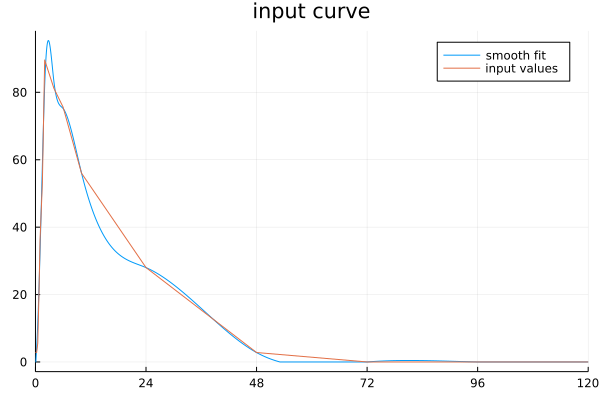

Defined IKK input curve.
All callbacks defined
adding NFkB module
removing:  -> tcRel as it is included in linking file
removing: RelA ->  as it is included in linking file
removing: cRel ->  as it is included in linking file
adding module NFkB to combined reaction array
finished NFkB

adding cellCycle module
removing:  -> GM as it is included in linking file
removing:  -> Mass as it is included in linking file
removing:  -> cycD as it is included in linking file
adding module cellCycle to combined reaction array
finished cellCycle

adding apoptosis module
removing:  -> L as it is included in linking file
removing: L ->  as it is included in linking file
removing: L ->  as it is included in linking file
adding module apoptosis to combined reaction array
finished apoptosis

adding differentiation module
removing:  -> IRF4 as it is included in linking file
removing:  -> cRel as it is included in linking file
removing: cRel ->  as it is included in linking file
removing:  -> RelA as it is

In [40]:
# get data for individual patient
patient_df = subset(CombOp, :PATIENT => ByRow(==("DLBCL-LS2978")))

# get mutations
muts = Vector(patient_df[!, :GeneAlt])
conds = GenConds(muts)
muts_count = combine(groupby(conds, [:Param, :Val]), nrow => :count)

######################
### Set conditions ###
######################

# set patient name
patient = patient_df[1,1]

conditions = ["all_mut"]

# get conditions
conds_run = GenConds2(muts_count)

# set params to change
global paramsToChange = [conds_run[1]]

# set modifyAmounts
global modifyAmount = [conds_run[2]]

print("Simulating mutations for "*patient*"...")

# run simulation
runSim(patient,conditions,paramsToChange,modifyAmount)

###########################################################################

In [ ]:
## loop to add new mutations and params to dictionary
function patients_single(patient_name)
    
    # get data for individual patient
    patient_df = subset(CombOp, :PATIENT => ByRow(==(patient_name)))
    
    # number of mutations
    n = nrow(patient_df)
    
    # get mutations
    muts = Vector(patient_df[!, :GeneAlt])
    
    # check genes are in dictionary
#     for i in 1:length(muts)
#     if haskey(param_mut, muts[i]) == false
#         println(muts[i]*" is not in the dictionary " )
#         @goto next
#         else 
#          continue
#     end
#     end
        
    ######################
    ### Set conditions ###
    ######################
    
    # set patient name
    patient = patient_name
    
    conditions = ["all_mut"]
                        
    # set modifyAmounts
    global modifyAmount = MA_all(muts,n)
    
    # set params to change
    global paramsToChange = P2C_all(muts,n)
                        
    print("Simulating "*string(n)*" mutations for "*patient*"...")
    
    # run simulation
    runSim(patient,conditions,paramsToChange,modifyAmount)
    
    @label next
end        

In [ ]:
patients_single("DLBCL-LS4619")

In [ ]:
patientSims = readdir("SSDoutputs/allMutSims/")
show(stdout, "text/plain", patientSims)

In [ ]:
patients_noSim = setdiff!(patients, patientSims)
show(stdout, "text/plain", patients_noSim)

## Chronic IKK 

In [ ]:
function P2C_IKK(genes)
    paramsToChange=[["k2_scalingNumber-NFkB"]]
    all_mut = []
        for i in genes
            push!(paramsToChange, [param_mut[i], "k2_scalingNumber-NFkB"])
            push!(all_mut, param_mut[i])
        end
    push!(all_mut, "k2_scalingNumber-NFkB")
    push!(paramsToChange, all_mut)
    return(paramsToChange)
end

In [ ]:
function MA_IKK(CNAs, IKK)
    modifyAmount=[[10.0]]
    all_mut = []
        for i in 1:length(CNAs)
            if CNAs[i] == "AMP"
                push!(modifyAmount, [1.5, IKK])
                push!(all_mut, 1.5)
            else
                push!(modifyAmount, [0.5, IKK])
                push!(all_mut, 0.5)
            end
        end
    push!(all_mut, IKK)
    push!(modifyAmount, all_mut)
    return(modifyAmount)
end

In [ ]:
patients_list = ["DLBCL-LS1546", "DLBCL-LS1683", "DLBCL-LS1899",
                "DLBCL-LS2590", "DLBCL-LS2596", "DLBCL-LS2599", "DLBCL-LS3085"]

In [ ]:
global IKK = 10.0

In [ ]:
for i in 1:length(patients_list)
    
    # get data for individual patient
    patient_df = subset(patient_data, :PATIENT => ByRow(==(patients_list[i])))
    
    # get genes
    genes = Vector(patient_df[!, :GENE])
    
    # check genes are in dictionary
    for i in 1:length(genes)
    if haskey(param_mut, genes[i]) == false
        @goto next
    else print(genes[i]*" is in the dictionary " )
         println()
    end
    end
    
    # get mutations
    CNAs = Vector(patient_df[!, :ALTERATION])
    
    ###########################################################################
    ### Mutation stuff ########################################################
    ###########################################################################
    
    # set patient name
    patient = patient_df[1,1]*"_IKK"*string(IKK)
    
    # set conditions
    n = nrow(patient_df)
    
    if n==2
            conditions= ["WT", patient_df[!, :GENE][1], patient_df[!, :GENE][2], "all_mut"]
        elseif n==3 
            conditions= ["WT", patient_df[!, :GENE][1], patient_df[!, :GENE][2],
                        patient_df[!, :GENE][3], "all_mut"]
        elseif n==4 
            conditions= ["WT", patient_df[!, :GENE][1], patient_df[!, :GENE][2],
                        patient_df[!, :GENE][3], patient_df[!, :GENE][4], "all_mut"]
        elseif n==5 
            conditions= ["WT", patient_df[!, :GENE][1], patient_df[!, :GENE][2],
                        patient_df[!, :GENE][3], patient_df[!, :GENE][4],
                        patient_df[!, :GENE][5], "all_mut"]
        elseif n==6 
            conditions= ["WT", patient_df[!, :GENE][1], patient_df[!, :GENE][2],
                        patient_df[!, :GENE][3], patient_df[!, :GENE][4],
                        patient_df[!, :GENE][5], patient_df[!, :GENE][6], "all_mut"]
        else continue
        end
                        
    # set modifyAmounts
    global modifyAmount = MA_IKK(CNAs, IKK)
    
    # set params to change
    global paramsToChange = P2C_IKK(genes)
                        
    print("Simulating "*string(n)*" mutations for "*patient*"...")
    
    # run simulation
    runSim(patient,conditions,paramsToChange,modifyAmount)
    
    @label next
end        
    ###########################################################################